In [2]:
import os
import json
from PIL import Image
import numpy as np
import tqdm

def get_traces_from_path(path):
    traces = {}
    for _, dir_names, _ in os.walk(path):
        for dir_name in dir_names:
            frames = []
            inputs = None
            for _, _, file_names in os.walk(f'{path}/{dir_name}'):
                for file_name in tqdm.tqdm(file_names):
                    if file_name.endswith('.png'):
                        image = Image.open(f'{path}/{dir_name}/{file_name}')

                        frames.append(np.array(image))
                    elif file_name.endswith('.json'):
                        with open(f'{path}/{dir_name}/{file_name}', 'r') as f:
                            inputs = json.loads(f.read())
            traces[dir_name] = list(zip(frames, inputs))
    return traces

traces = get_traces_from_path('../screenshots')

100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:03<00:00, 80.06it/s]


In [4]:
import matplotlib.pyplot as plt
import copy

def get_examples_from_traces(traces, decimate_factor=8):
    examples = []
    for trace, zipped in traces.items():
        for image, inputs in zipped:
            for offset in range(decimate_factor):
                decimated_frame = image[offset::decimate_factor, offset::decimate_factor]

                examples.append((decimated_frame, inputs[1:]))

    return examples

def get_mirrors_from_examples(examples):
    mirrors = []

    for (frame, inputs) in examples:
        mirror_frame = frame[:,::-1,:]
        mirror_inputs = copy.copy(inputs)
        mirror_inputs[0] *= -1

        mirrors.append((mirror_frame, mirror_inputs))

    return mirrors

examples = get_examples_from_traces(traces)       
mirrors = get_mirrors_from_examples(examples)

[-1.0, 0.99609375, 0, 0, 0]


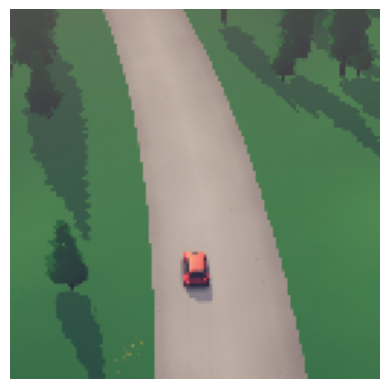

[1.0, 0.99609375, 0, 0, 0]


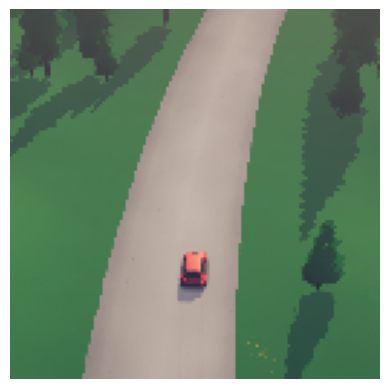

In [20]:
# Validate Mirroring logic works (CGTOW)

first_nonzero_steering_idx = None

for idx, (_, inputs) in enumerate(examples):
    if inputs[0] == 0:
        continue

    first_nonzero_steering_idx = idx
    break

if first_nonzero_steering_idx is None:
    raise ValueError('no throttle!')

image, inputs = examples[first_nonzero_steering_idx]
print(inputs)
plt.imshow(image)
plt.axis('off')
plt.show()

image, inputs = mirrors[first_nonzero_steering_idx]
print(inputs)
plt.imshow(image)
plt.axis('off')
plt.show()

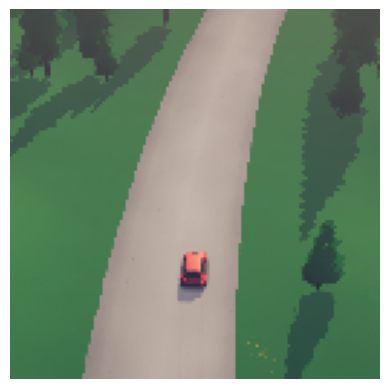

In [30]:
greyscale = (image[:,:,0] + image[:,:,1] + image[:,:,2])/768.0

plt.imshow(image)
plt.axis('off')
plt.show()

In [10]:
combined = examples + mirrors

np.random.shuffle(combined)

image_data = np.array([image for image, label in combined])
label_data = np.array([label for image, label in combined])

print(image_data.shape, label_data.shape)

(13120, 128, 128, 3) (13120, 5)


In [32]:
import torch
import torch.nn as nn
import torchvision.models as models

def create_resnet_model(num_classes=5, pretrained=False):
    """Creates a ResNet model with a custom classifier head (two dense layers)."""
    model = models.resnet18(pretrained=pretrained)
    in_features = model.fc.in_features

    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),  # First dense layer
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout after the first layer (optional)
        nn.Linear(512, 256),  # Second dense layer
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout after the second layer (optional)
        nn.Linear(256, num_classes)  # Output layer
    )

    return model

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    """
    Trains the given model.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        num_epochs (int): The number of training epochs.

    Returns:
        None (prints training progress and validation loss).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move the model to the GPU if available

    for epoch in range(num_epochs):
        model.train() # Set the model to training mode
        for images, labels in train_loader:
            images = images.to(device) # Move data to correct device
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # calculate the loss
            loss.backward() # backpropagation
            optimizer.step() # update the weights

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)
              val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

# Example usage:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset  # For demonstration

# Sample Data (Replace with your actual data)
# image_data = torch.randn(100, 3, 128, 128)  # 100 images, 3 channels, 128x128
# label_data = torch.randn(100, 5)       # 100 samples, 5 output values


# Data loaders (using dummy data for demonstration)
transform = transforms.Compose([transforms.ToTensor()]) # Add transforms as needed

partition_idx = int(label_data.shape[0] * 0.9)
train_dataset = TensorDataset(torch.from_numpy(image_data[:partition_idx]).permute(0, 3, 1, 2).float(), torch.from_numpy(label_data[:partition_idx]).float())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(image_data[partition_idx:]).permute(0, 3, 1, 2).float(), torch.from_numpy(label_data[partition_idx:]).float())
val_loader = DataLoader(val_dataset, batch_size=32)  # Use a separate validation set

In [36]:
# Model, Loss, Optimizer
model = create_resnet_model(num_classes=5, pretrained=True)
criterion = nn.MSELoss()  # Example: Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Example: Adam optimizer

# Training
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)




Epoch 1/100, Training Loss: 0.0444, Validation Loss: 0.0482
Epoch 2/100, Training Loss: 0.0338, Validation Loss: 0.0406
Epoch 3/100, Training Loss: 0.0179, Validation Loss: 0.0199
Epoch 4/100, Training Loss: 0.0178, Validation Loss: 0.0199
Epoch 5/100, Training Loss: 0.0103, Validation Loss: 0.0118
Epoch 6/100, Training Loss: 0.0119, Validation Loss: 0.0099
Epoch 7/100, Training Loss: 0.0074, Validation Loss: 0.0062
Epoch 8/100, Training Loss: 0.0073, Validation Loss: 0.0071
Epoch 9/100, Training Loss: 0.0128, Validation Loss: 0.0096
Epoch 10/100, Training Loss: 0.0065, Validation Loss: 0.0061
Epoch 11/100, Training Loss: 0.0060, Validation Loss: 0.0049
Epoch 12/100, Training Loss: 0.0055, Validation Loss: 0.0048
Epoch 13/100, Training Loss: 0.0044, Validation Loss: 0.0044
Epoch 14/100, Training Loss: 0.0049, Validation Loss: 0.0064
Epoch 15/100, Training Loss: 0.0064, Validation Loss: 0.0061
Epoch 16/100, Training Loss: 0.0080, Validation Loss: 0.0058
Epoch 17/100, Training Loss: 0.00

In [269]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_steering_idx = None

for idx, (image, inputs) in enumerate(combined):
    if inputs[0] == 0.0:
        continue

    first_steering_idx = idx
    break
    
test_image, test_inputs = combined[first_steering_idx]
# Example of how to use the trained model for inference
model.eval()
with torch.no_grad():
    example_image = torch.from_numpy(np.array([test_image])).permute(0,3,1,2).float().to(device) # Example image, needs to be a tensor
    output = model(example_image)
    output = output[0]

    for i in range(3,5):
        output[i] = 0.0 if output[i] < 0.5 else 1.0
  

print(test_inputs, output)

[-0.035186767578125, 0.0, 0.0, 0, 0] tensor([-0.0165,  0.0884,  0.0197,  0.0000,  0.0000], device='cuda:0')


In [271]:
# Save the model
torch.save(model.state_dict(), 'my_model.pth')